# Step 0. Setup Environment

Working Directory: `/content/bbar`

Device: CPU (It is fast without hardware accelerator)

## Step 0-1. Install Packages and Change Current Directory.

In [1]:
# Install RDKit and additional packages
!pip install rdkit-pypi
!pip install omegaconf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 30.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 KB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=c9be54018ef5c81e6b6751101a058b3c2a6abd2389d99ae2dc8f5507a831f24a
  Stored in directory: /root/.cache/pip/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime


In [2]:
# Import Pytorch Geometric
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 36.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━

In [3]:
import os
os.chdir('/content')
CODE_DIR = 'bbar'
!git clone https://github.com/SeonghwanSeo/BBAR.git $CODE_DIR
os.chdir(f'/content/{CODE_DIR}')

Cloning into 'bbar'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 254 (delta 115), reused 242 (delta 103), pack-reused 0
Receiving objects: 100% (254/254), 8.10 MiB | 9.68 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [4]:
!git checkout notebook

Branch 'notebook' set up to track remote branch 'notebook' from 'origin'.
Switched to a new branch 'notebook'


In [5]:
import gdown
if not os.path.exists('./test/pretrained_model') :
  os.chdir(f'./test')
  !gdown '16BK_tjOUmuMuWjSvV3TeLVc86PeAKig-'
  !tar -xvf './pretrained_model.tar'
  os.chdir(f'../')

Downloading...
From: https://drive.google.com/uc?id=16BK_tjOUmuMuWjSvV3TeLVc86PeAKig-
To: /content/bbar/test/pretrained_model.tar
100% 53.9M/53.9M [00:00<00:00, 182MB/s]
pretrained_model/
pretrained_model/3cl_affinity.tar
pretrained_model/logp.tar
pretrained_model/mw.tar
pretrained_model/qed.tar
pretrained_model/tpsa.tar
pretrained_model/logp_tpsa.tar


## Step 0-2. Import Packages

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from omegaconf import OmegaConf
from IPython.display import display, Image
import time

from bbar.generate import MoleculeBuilder

## Step 0-3. Util Functions

In [7]:
def display_molecule(mol, size=(300, 300)) :
    display(Chem.Draw.MolToImage(mol, size=size))

# Step 1. Generate a Single Molecule

## Step 1-0. TL;DR

Embed building block library and Save embedding matrix (first run)
The first run for each property takes 1~2 minutes.
After that, it takes about 5 seconds.
Input
- Core Molecule SMILES: 'c1ccccc1'
- Condition: {'mw': 300}

>>> generator.generate('c1ccccc1', {'mw': 300})
SMILES: Cc1ccc(C=C2C(=O)CN(c3ccc(C[NH3+])cc3)C2=O)o1
mw: 297.123	(Target: 300)


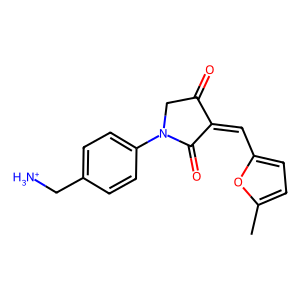

In [32]:
# Load Model
print('Embed building block library and Save embedding matrix (first run)')
print('The first run for each property takes 1~2 minutes.')
print('After that, it takes about 5 seconds.')
generator_config_path = './test/generation_config/mw.yaml'
generator_config = OmegaConf.load(generator_config_path)
generator = MoleculeBuilder(generator_config)

# Input
scaffold_smiles = 'c1ccccc1'
condition = {'mw': 300}

print('Input')
print(f"- Core Molecule SMILES: '{scaffold_smiles}'")
print(f'- Condition: {condition}')
print()
print(f">>> generator.generate('{scaffold_smiles}', {condition})")

# Generation
generated_mol = generator.generate(scaffold_smiles, condition)

# Print
generated_smiles = Chem.MolToSmiles(generated_mol)
print('SMILES:', generated_smiles)
property_value = Chem.Descriptors.ExactMolWt(generated_mol)
print(f'mw: {property_value:.3f}\t(Target: 300)')

# Display
display_molecule(generated_mol)

## Step 1-1. Select Experiment Type

Select the property of interest.

Available property list
- mw (Molecular Weight)
- logp (simple log water-octanol partition coefficient)
- tpsa (topological polar surface area)
- qed (Quantitative Estimation of Drug-likeness)

In [9]:
# Config
property_name = input('Property: ')   # Among 'mw', 'logp', 'tpsa', 'qed'
assert property_name in ['mw', 'logp', 'tpsa', 'qed']

# Get property function
# property_value = property_fn(mol)
# ex) >> Chem.Descriptors.ExactMolWt(benzene)
#     78
if property_name == 'mw' :
    property_fn = Chem.Descriptors.ExactMolWt
elif property_name == 'logp': 
    property_fn = Chem.Descriptors.MolLogP
elif property_name == 'tpsa': 
    property_fn = Chem.Descriptors.TPSA
elif property_name == 'qed': 
    property_fn = Chem.Descriptors.qed

Property: qed


## Step 1-2. Setup Generator

For the first run for each property, generator encodes building block library and save embedding matrix.

It takes about 1~2 minutes.


After that, it takes about 5 seconds.

In [10]:
generator_config_path = f'./test/generation_config/{property_name}.yaml'
generator_config = OmegaConf.load(generator_config_path)
print(OmegaConf.to_yaml(generator_config))
generator = MoleculeBuilder(generator_config)

model_path: ./test/pretrained_model/qed.tar
library_path: ./data/ZINC/library.csv
library_builtin_model_path: ./test/builtin_model/qed.tar
window_size: 2000
alpha: 0.75
max_iteration: 10



In [11]:
# Check Model Size (non-embeded model vs embeded model)
print('Model Parameter File')
!du -sh {generator_config.model_path}
print()
print('Library-Embedded Model Parameter File')
!du -sh {generator_config.library_builtin_model_path}

Model Parameter File
8.6M	./test/pretrained_model/qed.tar

Library-Embedded Model Parameter File
45M	./test/builtin_model/qed.tar


## Step 1-3. Set Scaffold (Core Molecule)

Example SMILES
- `'c1ccccc1'` (benzene)
- `'CC1C(=O)CCCC1'` (2-methyl cyclohexanone)
- `'[nH]1cccc1'` (Pyrrole)
- `'c1ccc2[nH]ccc2c1'` (Indole)

SMILES: c1ccc2[nH]ccc2c1


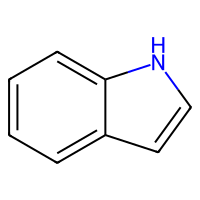

In [12]:
#scaffold_smiles = 'c1ccccc1'
scaffold_smiles = input('SMILES: ')
scaffold_mol = Chem.MolFromSmiles(scaffold_smiles)
display_molecule(scaffold_mol, size=(200, 200))

## Step 1-4. Set Target Condition

Example Condition

- **MolWt**: 200, 250, 300, 350, 400, 450, 500, 550

- **logP**: -4, -2, 0, 2, 4, 6, 8

- **TPSA**: 40, 60, 80, 100, 120, 140, 160, 180

- **QED**: 0.2, 0.4, 0.6, 0.8, 1.0

In [13]:
target_condition = float(input(f'Target {property_name}: '))

Target qed: 0.8


## Step 1-5. Generate a Single Molecule

Input
- Core Molecule SMILES: 'c1ccc2[nH]ccc2c1'
- Condition: {'qed': 0.8}

>>> generator.generate('c1ccc2[nH]ccc2c1', {'qed': 0.8})
Generation Success
SMILES: CSc1ccc2c(C(C(N)=S)N3CC(C)OC(C)C3)c[nH]c2c1
qed: 0.655	(Target: 0.8)


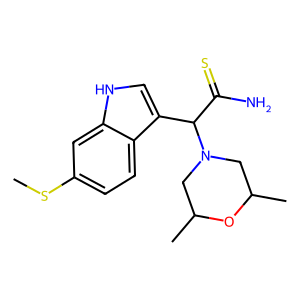

In [14]:
condition = {property_name: target_condition}
print('Input')
print(f"- Core Molecule SMILES: '{scaffold_smiles}'")
print(f'- Condition: {condition}')
print()
print(f">>> generator.generate('{scaffold_smiles}', {condition})")
generated_mol, trajectory = generator.generate(scaffold_smiles, condition, return_traj = True)
if generated_mol is None :
    print('Generation Failed')
else :
    print('Generation Success')
    generated_smiles = Chem.MolToSmiles(generated_mol)
    print('SMILES:', generated_smiles)
    property_value = property_fn(generated_mol)
    print(f'{property_name}: {property_value:.3f}\t(Target: {target_condition})')
    display_molecule(generated_mol)

# Trajectory #
Scaffold
SMILES: c1ccc2[nH]ccc2c1
qed: 0.544	(Target: 0.8)


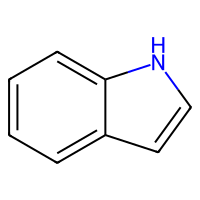


Step 1
SMILES: NC(=S)Cc1c[nH]c2ccccc12
qed: 0.711	(Target: 0.8)


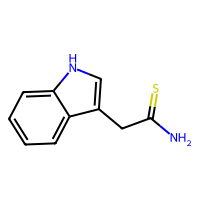


Step 2
SMILES: CC1CN(C(C(N)=S)c2c[nH]c3ccccc23)CC(C)O1
qed: 0.856	(Target: 0.8)


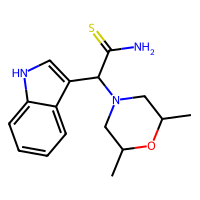


Step 3
SMILES: CSc1ccc2c(C(C(N)=S)N3CC(C)OC(C)C3)c[nH]c2c1
qed: 0.655	(Target: 0.8)


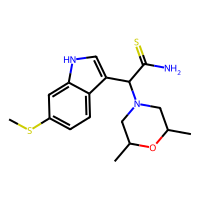

In [15]:
print('# Trajectory #')
for i, mol in enumerate(trajectory) :
    if i == 0 :
        print('Scaffold')
    else :
        print(f'Step {i}')
    smiles = Chem.MolToSmiles(mol)
    property_value = property_fn(mol)
    print('SMILES:', smiles)
    print(f'{property_name}: {property_value:.3f}\t(Target: {target_condition})')
    display_molecule(mol, size=(200, 200))
    print()

## Step 1-6. Summary

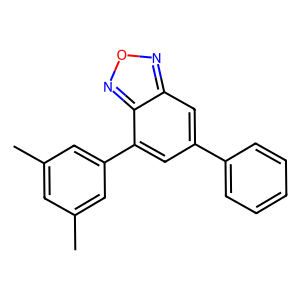

In [16]:
# Load Model
generator_config_path = './test/generation_config/mw.yaml'
generator_config = OmegaConf.load(generator_config_path)
generator = MoleculeBuilder(generator_config)

# Input
scaffold_smiles = 'c1ccccc1'
condition = {'mw': 300}

# Generation
mol = generator.generate(scaffold_smiles, condition)

# Display
display_molecule(mol)

#Step 2. Generate Molecules (Statistical Analysis)

## Step 2-1. Generation Setting
Run one of the among cells.

### MolWt

Target Condition List

>  200, 250, 300, 350, 400, 450, 500, 550


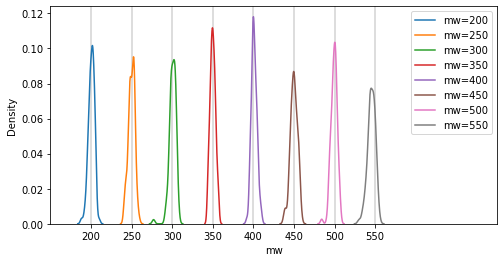

In [17]:
Image('./notebook/images/mw.png')

In [18]:
# Generation Setting (MW)
scaffold_smiles = 'c1ccccc1'
property_name = 'mw'
property_fn = Chem.Descriptors.ExactMolWt
num_samples = 100
target_condition_list = [200, 250, 300, 350, 400, 450, 500, 550]

# Graph Setup
property_xlim = [150, 700]

### TPSA

Target Condition List

>  40, 60, 80, 100, 120, 140, 160, 180




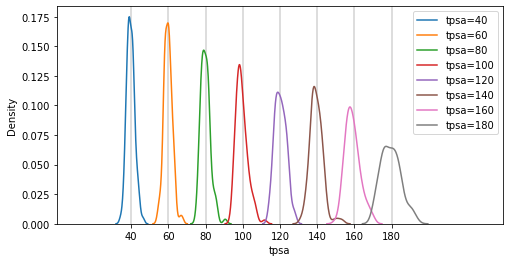

In [23]:
Image('./notebook/images/tpsa.png')

In [24]:
# Generation Setting (TPSA)
scaffold_smiles = 'c1ccccc1'
property_name = 'tpsa'
property_fn = Chem.Descriptors.TPSA
num_samples = 100
target_condition_list = [40, 60, 80, 100, 120, 140, 160, 180]

# Graph Setup
property_xlim = [0, 240]

### logP

Target Condition List

>  -4.0, -2.0, -0.0, 2.0, 4.0, 6.0, 8.0

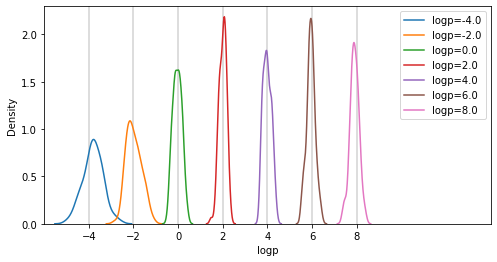

In [25]:
Image('./notebook/images/logp.png')

In [45]:
# Generation Setting (LogP)
scaffold_smiles = 'c1ccccc1'
property_name = 'logp'
property_fn = Chem.Descriptors.MolLogP
num_samples = 100
target_condition_list = [-4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0]

# Graph Setup
property_xlim = [-6, 14]

### QED
Target Condition List

>  0.2, 0.4, 0.6, 0.8, 1.0

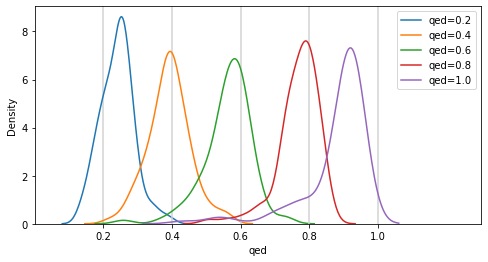

In [26]:
Image('./notebook/images/qed.png')

In [27]:
# Generation Setting (QED)
scaffold_smiles = 'c1ccccc1'
property_name = 'qed'
property_fn = Chem.Descriptors.qed
num_samples = 100
target_condition_list = [0.2, 0.4, 0.6, 0.8, 1.0]

# Graph Setup
property_xlim = [0, 1.3]

## Step 2-2. Generation

In [20]:
# Setup Generator
generator_config_path = f'./test/generation_config/{property_name}.yaml'
generator_config = OmegaConf.load(generator_config_path)
generator = MoleculeBuilder(generator_config)

# Run Generator
print('Generation Start!')
print(f'Core Molecule: {scaffold_smiles}')
generation_dict = {}
for target_condition in target_condition_list :
    generated_mol_list = []
    condition = {property_name: target_condition}
    print(f'{property_name}: {target_condition}', end='\t')

    st = time.time()
    for _ in range(num_samples) :
        mol = generator.generate(scaffold_smiles, condition)
        if mol is not None :
            generated_mol_list.append(mol)
    end = time.time()
    time_cost = end - st
    generation_dict[target_condition] = generated_mol_list
    print(f'Success: {len(generated_mol_list)}/{num_samples}\t{time_cost/num_samples:.3f} sec/mol')

Generation Start!
Core Molecule: c1ccccc1
mw: 200	Success: 100/100	0.051 sec/mol
mw: 250	Success: 100/100	0.052 sec/mol
mw: 300	Success: 100/100	0.061 sec/mol
mw: 350	Success: 100/100	0.078 sec/mol
mw: 400	Success: 100/100	0.075 sec/mol
mw: 450	Success: 100/100	0.090 sec/mol
mw: 500	Success: 100/100	0.089 sec/mol
mw: 550	Success: 100/100	0.091 sec/mol


## Step 2-3. Draw Distribution Graph

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

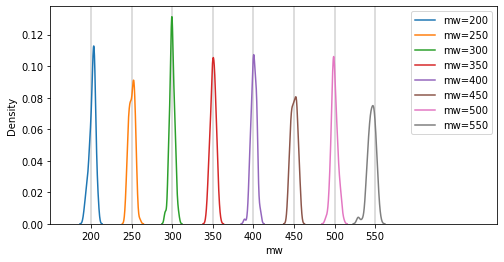

In [22]:
plt.figure(figsize=(8,4))
for target_condition in target_condition_list :
    generated_mol_list = generation_dict[target_condition]
    property_value_list = [property_fn(mol) for mol in generated_mol_list]
    plt.axvline(target_condition, color='lightgrey')
    sns.kdeplot(property_value_list, label=f'{property_name}={target_condition}')
plt.xlim(property_xlim)
plt.xlabel(property_name)
plt.xticks(target_condition_list)
plt.legend()
plt.show()

# Step 3. Multi-Conditional Generation
Target Condition List

LogP: 
> 2.0, 4.0, 6.0

TPSA:
> 40, 100, 160

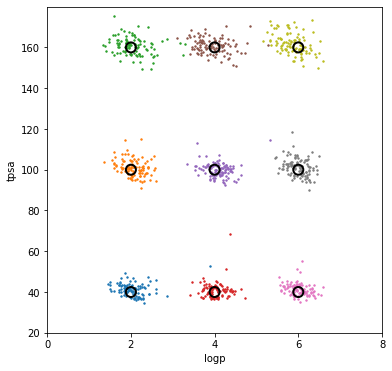

In [28]:
Image('./notebook/images/logp_tpsa.png')

In [31]:
target_logp_list = [2.0, 4.0, 6.0]
target_tpsa_list = [40, 100, 160]

# Setup Generator
generator_config_path = f'./test/generation_config/logp_tpsa.yaml'
generator_config = OmegaConf.load(generator_config_path)
generator = MoleculeBuilder(generator_config)

# Run Generator
print('Generation Start!')
print(f'Core Molecule: {scaffold_smiles}')
generation_dict = {}
for target_logp in target_logp_list :
    for target_tpsa in target_tpsa_list :
        generated_mol_list = []
        condition = {'logp': target_logp, 'tpsa': target_tpsa}
        print(f'logp: {target_logp} tpsa: {target_tpsa}', end='\t')
        st = time.time()
        for _ in range(num_samples) :
            mol = generator.generate(scaffold_smiles, condition)
            if mol is not None :
                generated_mol_list.append(mol)
        end = time.time()
        time_cost = end - st
        generation_dict[(target_logp, target_tpsa)] = generated_mol_list
        print(f'Success: {len(generated_mol_list)}/{num_samples}\t{time_cost/num_samples:.3f} sec/mol')

Generation Start!
Core Molecule: c1ccccc1
logp: 2.0 tpsa: 40	Success: 100/100	0.084 sec/mol
logp: 2.0 tpsa: 100	Success: 100/100	0.089 sec/mol
logp: 2.0 tpsa: 160	Success: 100/100	0.096 sec/mol
logp: 4.0 tpsa: 40	Success: 100/100	0.079 sec/mol
logp: 4.0 tpsa: 100	Success: 100/100	0.088 sec/mol
logp: 4.0 tpsa: 160	Success: 100/100	0.101 sec/mol
logp: 6.0 tpsa: 40	Success: 100/100	0.077 sec/mol
logp: 6.0 tpsa: 100	Success: 100/100	0.111 sec/mol
logp: 6.0 tpsa: 160	Success: 100/100	0.113 sec/mol


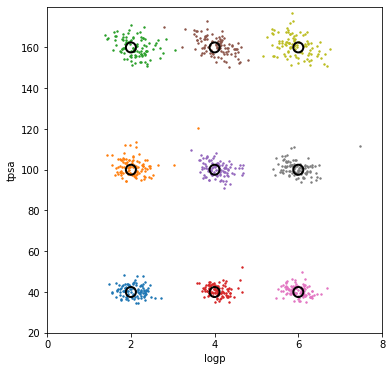

In [33]:
fig = plt.figure(figsize=(6,6))
t = 0
for target_logp in target_logp_list :
    for target_tpsa in target_tpsa_list :
        generated_mol_list = generation_dict[(target_logp, target_tpsa)]
        xs = [Chem.Descriptors.MolLogP(mol) for mol in generated_mol_list]
        ys = [Chem.Descriptors.TPSA(mol) for mol in generated_mol_list]
        plt.scatter(xs, ys, s=2)
        t+=1

for target_logp in target_logp_list :
    for target_tpsa in target_tpsa_list :
        plt.scatter(target_logp, target_tpsa, marker='o', facecolor = 'none', edgecolors='k', linewidths=2, s=100)

plt.xlim(0, 8)
plt.xticks([0, 2, 4, 6, 8])
plt.ylim(20, 180)
plt.yticks([20, 40, 60, 80, 100, 120, 140, 160])
plt.xlabel('logp')
plt.ylabel('tpsa')
plt.show()

# Step 4. Design inhibitors against 3CL Protease of SARS-Cov-2



##Reference Ligand

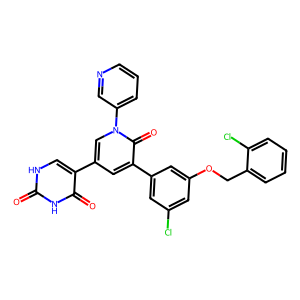

In [34]:
Image('./notebook/images/reference_ligand.png')

##Generation

Generation Start!
Core Molecule: c1ccccc1

CC1=C(C2CC(=O)Nc3cc4c(cc32)C[NH+]=N4)C(c2ccc(-c3nc4ccccc4[nH]3)cc2)N(C)N1


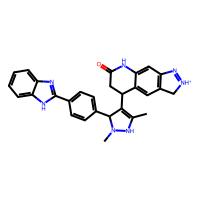


Cc1ccc2c(c1)=C1SC(c3cccc(C4CC(C(=O)N5CCOCC5)=NN4c4ccccc4)c3)C=C1C(=O)[NH+]=2


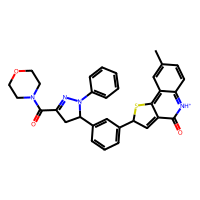


Cc1ccc2oc(-c3cccc(-c4nc5c(c(=O)n(-c6ccccc6C)c(=O)n5C)n4C)c3)nc2c1


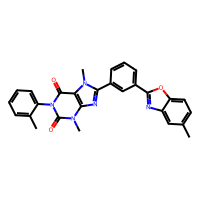


Cc1ccc(-c2ccc3[nH]c(CC(=O)NNC(=O)C(=Cc4ccc(O)cc4)c4ccccc4)nc3c2)cc1C


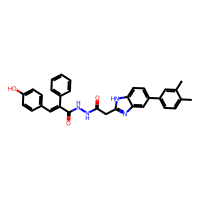


O=c1[nH]c2ccccc2c(=O)n1C1C(O)=Nc2c(ncn2-c2ccccc2)C1c1ccc(F)cc1


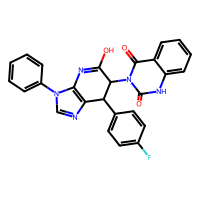

In [36]:
# Generation Setting (3CL)
scaffold_smiles = 'c1ccccc1'
property_name = 'affinity'
target_condition = -10

# Setup Generator
generator_config_path = f'./test/generation_config/3cl_affinity.yaml'
generator_config = OmegaConf.load(generator_config_path)
generator = MoleculeBuilder(generator_config)

# Run Generator
print('Generation Start!')
print(f'Core Molecule: {scaffold_smiles}')
print()

for _ in range(5) :
    mol = generator.generate(scaffold_smiles, {'affinity': target_condition})
    if mol is not None :
        print(Chem.MolToSmiles(mol))
        display_molecule(mol, size=(200, 200))
        print()

